In [ ]:
#Importing necessary libraries
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import random_split,DataLoader
from torchvision import transforms, datasets
from torch import optim


In [ ]:
# training_set = Datasets.CIFAR10(root='./', download=True,
#                               transform=transforms.ToTensor()
transform=transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor()])

full_train_dataset=torchvision.datasets.CIFAR10(root="./data",train = True,transform=transform,download=True)
val_size=int(0.2*len(full_train_dataset))
train_size=len(full_train_dataset)-val_size

train_dataset,val_dataset=random_split(full_train_dataset,[train_size,val_size])


train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
val_loader=DataLoader(train_dataset,batch_size=64,shuffle=False)

test_dataset=torchvision.datasets.CIFAR10(root="./data",train=False,transform=transform,download=True)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
for i in train_loader:
  print(i[0].shape)
  single_image = i[0]

  break
# print(train_loader.shape)

torch.Size([64, 3, 32, 32])


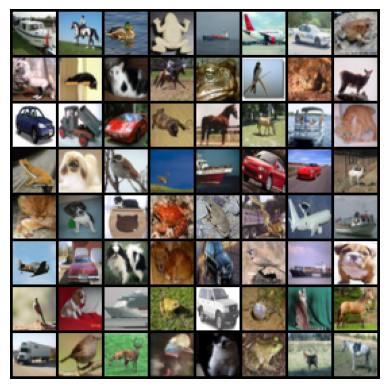

In [ ]:

import matplotlib.pyplot as plt
from torchvision.utils import make_grid
def visualize_batch(batch):
    grid = make_grid(batch, nrow=8)  # Assuming you want to display 8 images in each row
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

# Iterate through the DataLoader and visualize a batch
for batch_data, _ in train_loader:
    # Assuming batch_data has the size [64, 3, 3, 3]
    visualize_batch(batch_data)
      # To visualize only the first batch
    break

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
class autoencoder(nn.Module):
  def __init__(self):
    super(autoencoder,self).__init__()
    #encoderBlock
    self.el1 = nn.Sequential(nn.Conv2d(in_channels= 3, out_channels=64, kernel_size= 3 , stride=1, padding=2),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d(3),
        )
    #decoder
    self.dl1 = nn.Sequential(nn.Conv2d(in_channels = 64 , out_channels = 3 , kernel_size = 3 , stride = 1 , padding = 2 ),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d(3),
            nn.Softmax2d(),)
    # for word function
  def forward(self, x):
      x = self.el1(x)
      x = self.dl1(x)
      return x



In [ ]:
modle1 = autoencoder().to(device)

In [ ]:

criterion = nn.MSELoss()
optimizer = optim.Adam(modle1.parameters(), lr = 0.001)

In [ ]:

# Lists to store training and test loss for plotting
train_loss_list = []
test_loss_list = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    modle1.train()
    train_loss = 0.0
    for data in train_loader:
        img, _ = data
        img = img.to(device)  # Move input data to GPU
        optimizer.zero_grad()
        outputs = modle1(img)
        loss = criterion(outputs, img)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation loss
    autoencoder.eval()
    test_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            img, _ = data
            img = img.to(device)  # Move input data to GPU
            reconstructions = autoencoder(img)
            loss = criterion(reconstructions, img)
            test_loss += loss.item()

    # Average losses
    train_loss /= len(train_loader)
    test_loss /= len(test_loader)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 3, 32, 32])) that is different to the input size (torch.Size([64, 3, 3, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (3) must match the size of tensor b (32) at non-singleton dimension 3

In [ ]:
print(train_loss_list )

[1.5539012849807738, 1.5539012849807738, 1.5539012849807738, 1.5539012840270996, 1.5539012817382813]


In [ ]:
# val_loss_list = []

# num_epochs = 10
# for epoch in range(num_epochs):
#     modle1.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for data in val_loader:
#             img, _ = data
#             img = img.to(device)
#             reconstructions = modle1(img)
#             loss = criterion(reconstructions, img)
#             val_loss += loss.item()

#     val_loss /= len(test_loader)
#     val_loss_list.append(val_loss)
#     print(f'Epoch [{epoch+1}/{num_epochs}],Test Loss: {val_loss:.4f}')

In [ ]:
modle1.eval()
test_loss = 0.0

with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.to(device)

        outputs = modle1(img)
        loss = criterion(outputs, img)
        test_loss += loss.item()

print(f'Testing Loss: {test_loss / len(test_loader)}')

Testing Loss: 1.5636835348833897


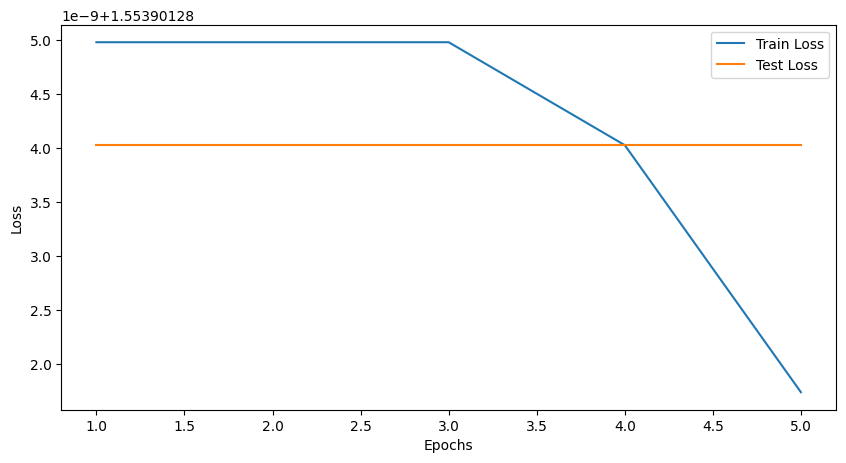

In [ ]:
# Plotting the training and test loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_loss_list, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

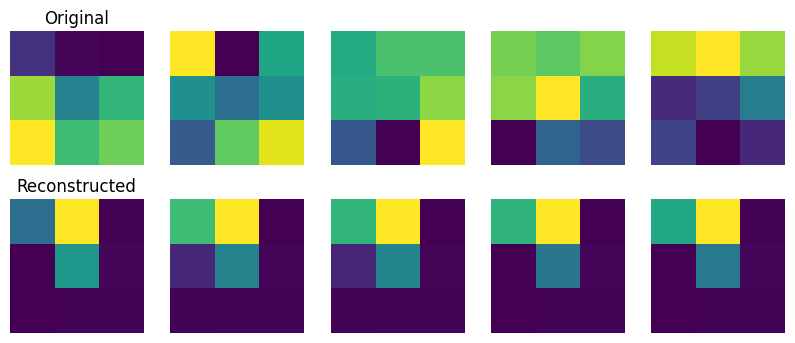

In [ ]:
def plot_images(original, reconstructed):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))  # Increase the grid size to 5 images
    for i in range(5):
        axes[0, i].imshow(original[i][0].cpu().numpy())  # Move to CPU for plotting
        axes[1, i].imshow(reconstructed[i][0].cpu().numpy())  # Move to CPU for plotting
        axes[0, i].axis('off')
        axes[1, i].axis('off')
    axes[0, 0].set_title('Original')
    axes[1, 0].set_title('Reconstructed')
    plt.show()

plot_images(img, reconstructions)
